# Homework 9: Moar linear models.

*Instructions:*
Please answer the following questions and submit your work
by editing this jupyter notebook and submitting it on Canvas.
Questions may involve math, programming, or neither,
but you should make sure to *explain your work*:
i.e., you should usually have a cell with at least a few sentences
explaining what you are doing.

Also, please be sure to always specify units of any quantities that have units,
and label axes of plots (again, with units when appropriate).

In [24]:
import numpy as np
import matplotlib.pyplot as plt
rng = np.random.default_rng(123)
from sklearn.linear_model import LogisticRegression, PoissonRegressor
import pandas as pd
from scipy import stats
from collections import defaultdict
from sklearn.model_selection import train_test_split

# 1. Logistic hypotheticals

Make up a situation in which you might have data like:
$$ Y_i \sim \text{Binomial}\left(1, \frac{1}{1 + e^{-a + b X_i}} \right) . $$
(In other words, $Y_i = 0$ or 1 with logistic probabilities.)

*(a)* Describe the situation in words, including choosing values for $a$ and $b$.
    Make a plot of $ \frac{1}{1 + e^{-a + b x}}$ against $x$.
    
*(b)* Simulate 1000 observations from this model (with values for $X$ drawn from some reasonable distribution).

*(c)* Fit a logistic linear model to your simulated data.
    Identify the estimates of $a$ and $b$ (they should be close to the real values!).

### Problem 1(a) - Logistic Hypothetical

Imagine a coffee company is modeling the probability of a customer purchasing a premium subscription based on daily coffee consumption. The model:

$P(\text{Purchase}) = \frac{1}{1 + e^{-(-3 + 0.8X)}}$

- \(X\) = daily cups of coffee.
- \(a = -3\): baseline log-odds of purchasing (low chance at 0 cups).
- \(b = 0.8\): positive effect per additional cup.

Example probabilities:
- \(X = 0\) cups: ~4.7% chance.
- \(X = 5\) cups: ~55% chance.
- \(X = 10\) cups: ~96% chance.

The plot of \(P\) vs. \(X\) shows a classic **S-shaped logistic curve**.


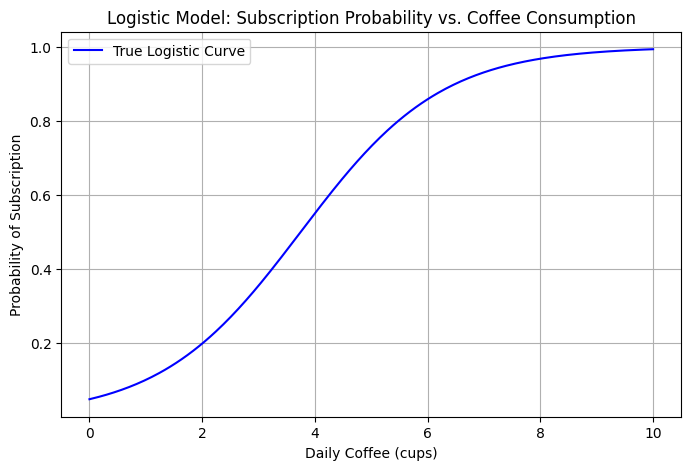

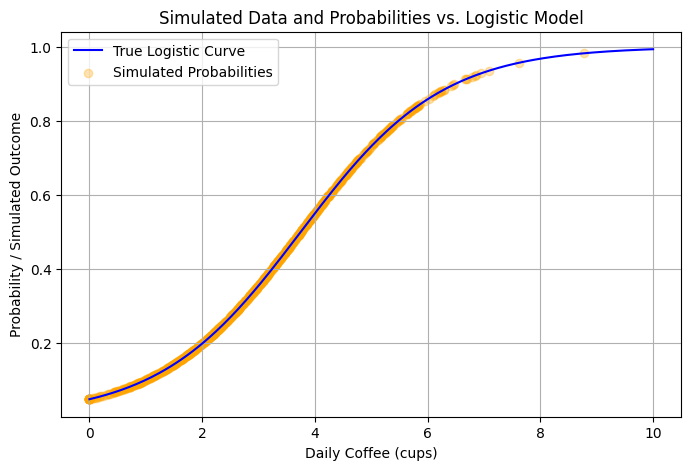

True a = -3, Estimated a = -2.9277
True b = 0.8, Estimated b = 0.8032


In [25]:
# True logistic parameters
a_true = -3
b_true = 0.8

# (a) Logistic model plot
x_vals = np.linspace(0, 10, 300)
p_vals = 1 / (1 + np.exp(-(a_true + b_true * x_vals)))

plt.figure(figsize=(8,5))
plt.plot(x_vals, p_vals, label="True Logistic Curve", color='blue')
plt.xlabel("Daily Coffee (cups)")
plt.ylabel("Probability of Subscription")
plt.title("Logistic Model: Subscription Probability vs. Coffee Consumption")
plt.grid(True)
plt.legend()
plt.show()

# (b) Simulate 1000 observations
np.random.seed(42)
X_sim = np.random.normal(loc=3, scale=1.5, size=1000)
X_sim = np.clip(X_sim, 0, None)  # Coffee cups can't be negative

linear_term = a_true + b_true * X_sim
p_sim = 1 / (1 + np.exp(-linear_term))
Y_sim = np.random.binomial(1, p_sim)

# Scatter plot of simulated data over true logistic curve
plt.figure(figsize=(8,5))
plt.plot(x_vals, p_vals, label="True Logistic Curve", color='blue')
plt.scatter(X_sim, p_sim, alpha=0.3, color="orange", label="Simulated Probabilities")
plt.xlabel("Daily Coffee (cups)")
plt.ylabel("Probability / Simulated Outcome")
plt.title("Simulated Data and Probabilities vs. Logistic Model")
plt.grid(True)
plt.legend()
plt.show()

# (c) Fit logistic model to simulated data
X_sim_reshaped = X_sim.reshape(-1, 1)
logreg = LogisticRegression(solver='lbfgs')
logreg.fit(X_sim_reshaped, Y_sim)

# Extract fitted parameters
b_est = logreg.coef_[0][0]
a_est = logreg.intercept_[0]

print(f"True a = {a_true}, Estimated a = {a_est:.4f}")
print(f"True b = {b_true}, Estimated b = {b_est:.4f}")


# 2. A new whale

In the file [data/whales.csv](data/whales.csv)
(direct link: [github](https://github.com/UOdsci/dsci345/raw/main/class_material/homeworks/data/whales.csv))
are the (average) body mass (in kg) and length (in m) of 43 modern cetacean species, from [this dataset](http://esapubs.org/archive/ecol/E090/184/metadata.htm).
Suppose that someone has found fossils of a new species of whale
that is about 8m long,
and they'd like to estimate how much it weighed,
based on the length-weight relationship of modern species.

*(a)* Read in the data and make a plot of mass against length.
    Also make a plot of log(mass) against log(length).

*(b)* Fit a linear model to predict log(mass) with log(length),
    i.e., find $a$ and $b$ so that
    $$ \log(\text{mass}) \approx a + b \log(\text{length}) , $$
    and add the resulting best-fit line to the plot of log(mass) against log(length).

*(c)* The predicted mass of a whale of length $\ell$ is $e^{a + b \log(\ell)}$.
    Add *this* line to the original plot of mass against length.

*(d)* What is the predicted weight of the 8m long whale?
    How far off do you estimate this prediction to be?
    (You can get the margin of error either by looking at the plot
    or computing the standard deviations of the residuals on a log scale, and transforming.)

Index(['Binomial', 'BodyMass', 'BodyLen'], dtype='object')


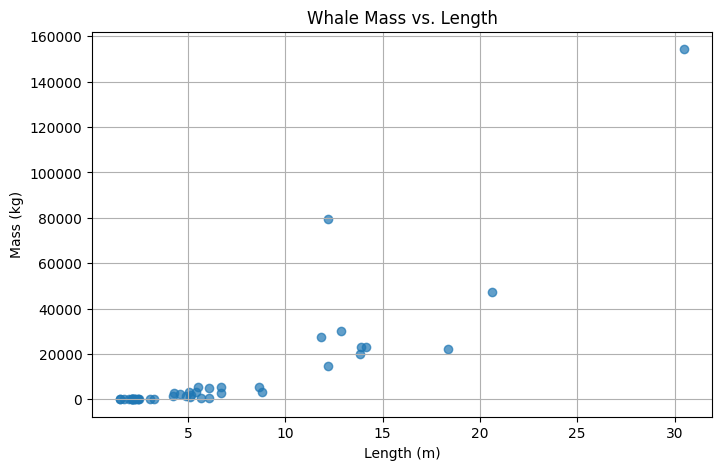

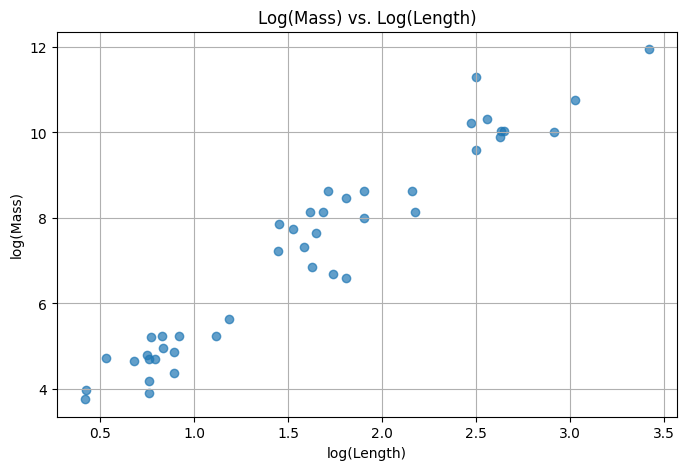

Fitted model: log(mass) = 2.6722 + 2.8386 * log(length)


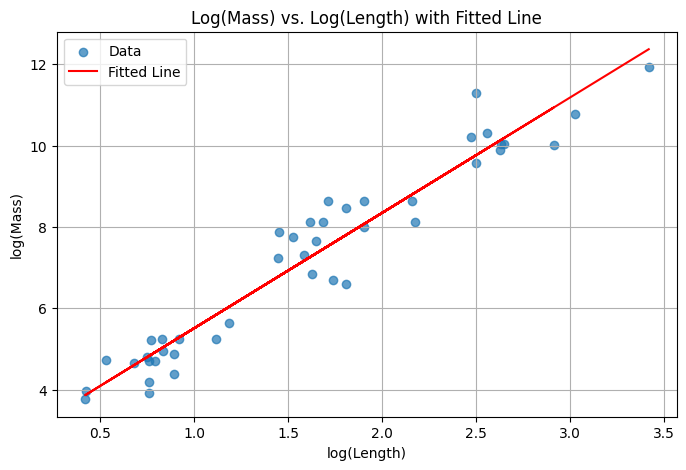

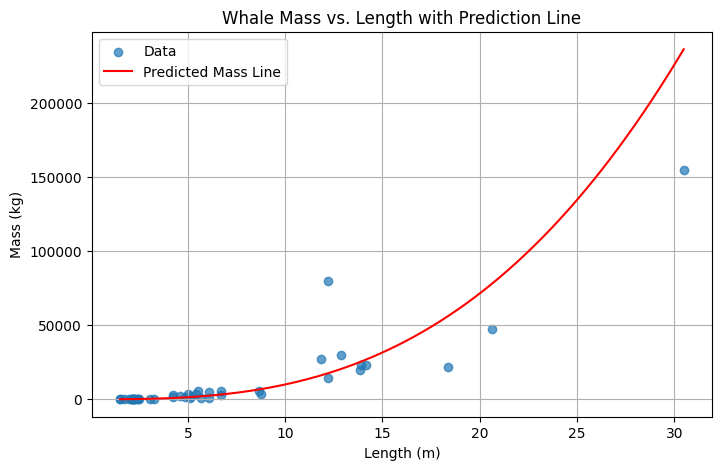

In [26]:
# 2(a) - Read data and make plots
whales = pd.read_csv("data/whales.csv")
# Check column names for safety
print(whales.columns)

# 2(a) Plot: mass vs. length
plt.figure(figsize=(8,5))
plt.scatter(whales['BodyLen'], whales['BodyMass'], alpha=0.7)
plt.xlabel("Length (m)")
plt.ylabel("Mass (kg)")
plt.title("Whale Mass vs. Length")
plt.grid(True)
plt.show()

# Plot: log(mass) vs. log(length)
log_length = np.log(whales['BodyLen'])
log_mass = np.log(whales['BodyMass'])

plt.figure(figsize=(8,5))
plt.scatter(log_length, log_mass, alpha=0.7)
plt.xlabel("log(Length)")
plt.ylabel("log(Mass)")
plt.title("Log(Mass) vs. Log(Length)")
plt.grid(True)
plt.show()

# 2(b) Fit linear model: log(mass) ~ log(length)
slope, intercept, r_value, p_value, std_err = stats.linregress(log_length, log_mass)
print(f"Fitted model: log(mass) = {intercept:.4f} + {slope:.4f} * log(length)")

# Add best-fit line to log-log plot
plt.figure(figsize=(8,5))
plt.scatter(log_length, log_mass, alpha=0.7, label="Data")
plt.plot(log_length, intercept + slope * log_length, color='red', label="Fitted Line")
plt.xlabel("log(Length)")
plt.ylabel("log(Mass)")
plt.title("Log(Mass) vs. Log(Length) with Fitted Line")
plt.grid(True)
plt.legend()
plt.show()

# 2(c) Add prediction line to original mass vs. length plot
length_grid = np.linspace(whales['BodyLen'].min(), whales['BodyLen'].max(), 200)
predicted_mass = np.exp(intercept + slope * np.log(length_grid))

plt.figure(figsize=(8,5))
plt.scatter(whales['BodyLen'], whales['BodyMass'], alpha=0.7, label="Data")
plt.plot(length_grid, predicted_mass, color='red', label="Predicted Mass Line")
plt.xlabel("Length (m)")
plt.ylabel("Mass (kg)")
plt.title("Whale Mass vs. Length with Prediction Line")
plt.grid(True)
plt.legend()
plt.show()



# 3. Find the whales

Recall the [word count data](data/passages.txt) 
(direct link: [github](https://github.com/UOdsci/dsci345/raw/main/class_material/homeworks/data/passages.txt))
that we used as an example for PCA:
there, we constructed the array `wordmat` so that `wordmat[i,j]` contains the number of times that `words[j]` appears in passage `i`,
using the following code:

In [27]:
pfile = open("data/passages.txt", "r")
passages = pfile.read().split("\n")[:-1]
sources = pd.read_table("data/passage_sources.tsv")
words = np.unique(" ".join(passages).split(" "))[1:]
def tabwords(x, words):
    d = defaultdict(int)
    for w in x.split(" "):
        d[w] += 1
    out = np.array([d[w] for w in words])
    return out

wordmat = np.array([tabwords(x, words) for x in passages])

We'll use this matrix to address the following problem:
predict the number of times that the words "whale" or "whales" appears in a given passage,
using occurrance counts of the other words.
To make this a little easier, we won't use *all* words, just those that appear between 100 and 5,000 times:

In [28]:
wordfreq = wordmat.sum(axis=0)
midwords = np.logical_and(np.logical_and(wordfreq > 100, wordfreq < 5000),
                          ~np.isin(words, ['whale', 'whales']))
has_whales = (wordmat[:,np.where(words == "whale")[0]] + wordmat[:,np.where(words == "whales")[0]]).flatten()
wordmat = wordmat[:, midwords]
words = words[midwords]

Your goal is to use `sklearn.PoissonRegressor` to fit a Poisson GLM that predicts `has_whales` from `X`.
To do this:

*(a)* Choose 90% of the data for training and the remaining 10% for testing.
    Write functions that fit a model with the training data,
    and compute the standard deviation of the residuals for the testing data from a fitted model.
    An argument to the first function should be `alpha`, which is passed on to `PoissonRegressor`.

*(b)* Fit the model with the argument `alpha=0`.
    This model should fit very poorly. Explain why.

*(c)* Fit models across a range of values of `alpha`, and display the size of their residuals (on testing data) as a table or plot.
    What is a good value for `alpha`?

*(d)* Describe the best-fitting value of `alpha` from (c): 
    how well does it predict,
    which words have the largest positive and negative coefficients in the model,
    and what does this mean? Are there any surprises?

In [ ]:
#3a)
#passages x selected words
X = wordmat
y = has_whales

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1)

#model fitting
def fit_model(alpha, X_train, y_train):
    #has_whales is a count variable (Poisson distribution)
    #alpha: controls regularization strength and higher alpha increases regularization
    model_whale = PoissonRegressor(alpha=alpha, max_iter=1000 0)
    model_whale.fit(X_train, y_train)
    return model_whale

#computes differences between true and predicted values
def compute_resid_std(model, X_test, y_test):
    y_pred = model.predict(X_test)
    residuals = y_test - y_pred
    return np.std(residuals)


In [30]:
#3b)
#fitting model with alpha of 0
model_alpha_0 = fit_model(alpha = 0.0, X_train = X_train, y_train = y_train)

std_resd_alpha_0 = compute_resid_std(model_alpha_0, X_test, y_test)
print(f"Standard deviation of residuals where alpha is 0: {std_resd_alpha_0:.2f}")


Standard deviation of residuals where alpha is 0: 269.22


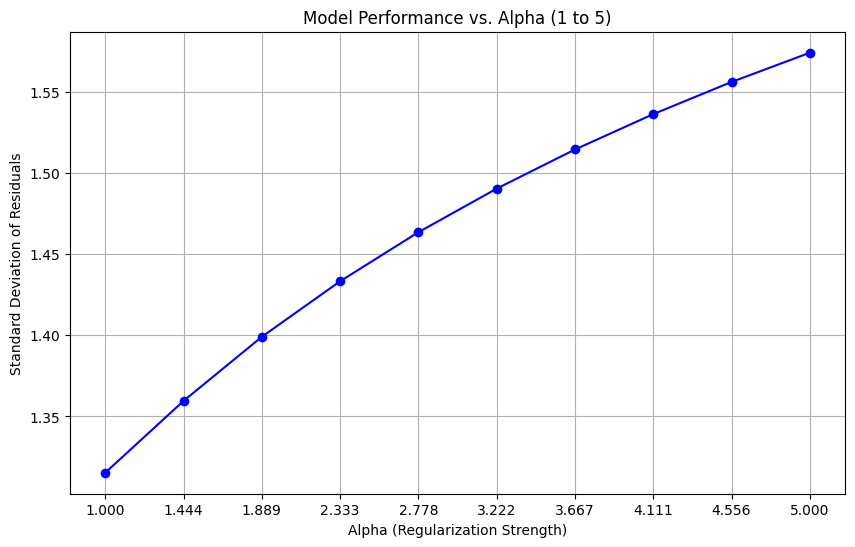


Best alpha value: 1.00
Lowest residual std: 1.3154


In [31]:

#3c)
#alpha values to test fititng the model with
alphas = np.linspace(1, 5, 10)
results = []
models = [] #used for finding best coefficents and words for finding whale predicting words

for alpha in alphas:
    #fitting model with alpha values
    model_whales = PoissonRegressor(alpha=alpha, max_iter=2000)
    model_whales.fit(X_train, y_train)
    models.append(model_whales)

    #calculates residuals on test data
    y_pred = model_whales.predict(X_test)
    resid = y_test - y_pred
    std_resid = np.std(resid)
    results.append({'alpha': alpha,
                   'resid_std': std_resid})

#converting alpha values and residuals to dataframe and plotting
results_df = pd.DataFrame(results)
plt.figure(figsize=(10, 6))
plt.plot(results_df['alpha'], results_df['resid_std'], 'bo-')
plt.xlabel('Alpha (Regularization Strength)')
plt.ylabel('Standard Deviation of Residuals')
plt.title('Model Performance vs. Alpha (1 to 5)')
plt.grid(True)
plt.xticks(alphas)  # Show all alpha values on x-axis
plt.show()


#Finding best alpha value for model
best_idx = np.argmin(results_df['resid_std'])
best_alpha = results_df.loc[best_idx, 'alpha']
best_std = results_df.loc[best_idx, 'resid_std']
best_model = models[best_idx]
print(f"\nBest alpha value: {best_alpha:.2f}")
print(f"Lowest residual std: {best_std:.4f}")


In [32]:

#3d) 
# #finding which words have the largest positive and negative coefficients in the model

#first finding coefficients and pair with their word
coef = best_model.coef_
word_coef = list(zip(words, coef))

sorted_word_coef = sorted(word_coef, key = lambda x: x[1], reverse=True)

#Printing top 5 positive predictors
for word, coef in sorted_word_coef[:5]:
    print(f"{word:>15}: {coef:+.2f}")

#printing top 5 negative predictors
for word, coef in sorted_word_coef[-5:]:
    print(f"{word:>15}: {coef:+.2f}")

          sperm: +0.16
            one: +0.09
          these: +0.08
           then: +0.08
          other: +0.08
          every: -0.06
           what: -0.07
      elizabeth: -0.07
         elinor: -0.07
            not: -0.10


**(d)**
The alpha value of 1.00 is most effective, as it strikes a balance between capturing meaningful whale-related word patterns and filtering out random noise in the data. With an alpha of 1.00, common words such as "the," "and," and other function words are suppressed, allowing the model to focus on more informative features. The print statement above displays the words with the highest and lowest coefficient values from the Poisson regression model. Words with positive coefficients increase the predicted whale word count, while words with negative coefficients decrease it.